# EGamma short exercise
This is the companion notebook to [SWGuideCMSDataAnalysisSchoolLPC2020EGammaExercise](https://twiki.cern.ch/twiki/bin/view/CMS/SWGuideCMSDataAnalysisSchoolLPC2020EGammaExercise).

Photons and electrons play a crucial role in the success of CMS. They were vital in the discovery of the Higgs boson and play an important role in searches for new physics and standard model measurements. The CMS detector features a high-resolution electromagnetic calorimeter (ECAL) and the world's largest active silicon tracker. These detectors provide clean object identification and excellent energy and momentum resolution of photons and electrons. In this exercise, we will examine photon and electron identification and study how these objects are used in physics analyses. We will start with [NanoAOD](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookNanoAOD) samples.

Table of contents:
   * [Finding samples](#Finding-samples)
   * [Using NanoAOD](#Using-NanoAOD)
   * [Ground truth](#Ground-truth)
   * [Common discriminating variables](#Common-discriminating-variables)
      * [Electron-specific variables](#Electron-specific-variables)
      * [Photon-specific variables](#Photon-specific-variables)

## Finding samples
Let's find two simulation samples to use for the remainder of the exercise: a $Z\rightarrow \ell^{+}\ell^{-}$ sample, which will contain two electrons in slightly more than 1/3 of the events (**Q: why greater than a third?**); and a sample of $\gamma+\text{jets}$ events, where a photon is radiated off either initial- or final-state quarks.  To find samples via a web browser, one can go to the [DAS client](https://cmsweb.cern.ch/das/) page.  Here, we use the `dasgoclient` command-line utility, using Jupyter notebook's shell execution shortcut.

The query format is `dasgoclient --query="key requirement [requirement ...]"` where the key is what type of record we are looking for, and each requirement helps filter results.  Here we want to find some datasets that match a wildcard pattern.  Datasets in CMS (mostly) follow a structured naming convention,

```/Primary/Campaign-Conditions-Revision/Datatier```,

where: `Primary` is the primary dataset type, either a particular set of triggers for real data, or a particular physics process for simulation; `Campaign` encodes the data reprocessing or simulation generating campaign, used by CMS computing to organize the computing workflows; `Conditions` specifies in more detail the reconstruction and/or simulation conditions of the dataset; `Revision` allows for replacement of invalid datasets or extensions (e.g. `_ext1` you might sometimes see); and `Datatier` describes what kind of format and content is in the ROOT files inside the dataset.  Below, we search for a simulation dataset for the Drell-Yan ($Z/\gamma^{*}$) process, where the decay is to two leptons (`ToLL`) and a generator-level mass cut of 50 GeV is imposed.  Adding `_Tune*` helps reduce the number of matches where additional generator cuts are present.  Try removing it to see what kind of exclusive phase spases samples are commonly generated for.  For the generation campaign, we choose the Autumn18 production, which corresponds to the 2018 data-taking conditions.

In [1]:
!dasgoclient --query="dataset dataset=/DYJetsToLL_M-50_Tune*/RunIIAutumn18NanoAODv5*/NANOAODSIM"

/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv5-Nano1June2019_102X_upgrade2018_realistic_v19-v1/NANOAODSIM
/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv5-Nano1June2019_102X_upgrade2018_realistic_v19_ext2-v1/NANOAODSIM
/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv5-Nano1June2019_102X_upgrade2018_realistic_v19-v1/NANOAODSIM


We see three results, all are produced with the [MadGraph5_aMC@NLO](https://twiki.cern.ch/twiki/bin/view/CMS/CitationsForGenerators#MadGraph5_a_MCatNLO) generator, where one simulates the Z+jets process at leading order (`madgraphMLM`), one at NLO (`amcatnloFXFX`), and one which is just an extension to increase the number of simulated events.  From here, it is possible albeit convoluted to see the original run cards that configured the MadGraph generator.  We tracked them down for you, so you can see what actually configures the event generation: [madgraphMLM card](https://github.com/cms-sw/genproductions/tree/1e06dc8f0c86ab6fdb547b27c43c92b022608b80/bin/MadGraph5_aMCatNLO/cards/production/2017/13TeV/DYJets_HT_LO_MLM/DYJets_HT_mll50/DYJets_HT-incl), [amcatnloFXFX card](https://github.com/cms-sw/genproductions/tree/59237cf5f41aed600b63fa8d071441129aeb6f9a/bin/MadGraph5_aMCatNLO/cards/production/2017/13TeV/dyellell012j_5f_NLO_FXFX
).

Let's use the LO sample.  Below, we query the files belonging to the dataset, and save them to a python variable.

In [2]:
dy_files = !dasgoclient --query="file dataset=/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv5-Nano1June2019_102X_upgrade2018_realistic_v19-v1/NANOAODSIM"
print("Number of files:", len(dy_files))

Number of files: 53


Now, for the photon event samples, since the inclusive production phase space is so large, we have to impose a minimum transverse energy sum requirement (`HT`, e.g. $\sum_{\text{particles}} p_{T}$) to be able to generate enough events in the phase space we are interested in (which is dictated by photon trigger thresholds).

In [3]:
!dasgoclient --query="dataset dataset=/GJets_HT-*/RunIIAutumn18NanoAODv5*/NANOAODSIM"

/GJets_HT-100To200_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv5-Nano1June2019_102X_upgrade2018_realistic_v19-v1/NANOAODSIM
/GJets_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv5-Nano1June2019_4cores5k_102X_upgrade2018_realistic_v19-v1/NANOAODSIM
/GJets_HT-200To400_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv5-Nano1June2019_102X_upgrade2018_realistic_v19-v1/NANOAODSIM
/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv5-Nano1June2019_102X_upgrade2018_realistic_v19-v1/NANOAODSIM
/GJets_HT-400To600_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv5-Nano1June2019_102X_upgrade2018_realistic_v19-v1/NANOAODSIM
/GJets_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv5-Nano1June2019_102X_upgrade2018_realistic_v19-v1/NANOAODSIM
/GJets_HT-40To100_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18

We see two types of generation configurations, one is inclusive and the other enforces at least two generator-level photons with a minimum invariant mass cut between them: `DoubleEMEnriched_MGG-80toInf`. (**Q: what might these `DoubleEMEnriched_MGG-80toInf` samples be useful for?**)

Let's use just one HT bin for our photon sample.  We will investigate how much that restricts the generated photon $p_{T}$.

In [4]:
gjets_files = !dasgoclient --query="file dataset=/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv5-Nano1June2019_102X_upgrade2018_realistic_v19-v1/NANOAODSIM"
print("Number of files:", len(gjets_files))

Number of files: 17


The files we've identified above are all LFNs (Logical File Names), and they alone don't specify where and how to read them.  For that, we need to specify a PFN (Physical File Name).  CMS operates a distributed data access system known as [AAA](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookXrootdService) which makes files available via the [xrootd protocol](https://xrootd.slac.stanford.edu/) regardless of their storage location.  In short, adding the prefix `root://cmsxrootd.fnal.gov/` to all the files makes them readable.

In [5]:
redirector = 'root://cmsxrootd.fnal.gov/'
dy_files = [redirector + f for f in dy_files]
gjets_files = [redirector + f for f in gjets_files]

## Using NanoAOD
In previous iterations of this exercise, students started by running an _NTuplizer_ over MiniAOD samples.  The [MiniAOD datatier](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookMiniAOD) contains enough detailed information to cover essentially all typical CMS analyses.  The EGamma-related content is discussed further in the [EgammaMiniAODV2](https://twiki.cern.ch/twiki/bin/viewauth/CMS/EgammaMiniAODV2) TWiki.  A concise example of accessing MiniAOD photon content is given [here](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookMiniAOD2017#Example_code_accessing_all_high).

A plethora of nTuplizers have been written over the past few years, all essentially extracting similar information from MiniAOD.  In an attempt to reduce code maintenence burden, a common nTuple, [NanoAOD](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookNanoAOD) was created.  It contains less information than MiniAOD, and is a much more compact file format, averaging 1-2 kB per event vs. MiniAOD's 30-50 kB per event.  In addition, NanoAOD saves all information in basic types (like `int`, `float`, etc.) rather than the [EDM format](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookCMSSWFramework#EdM) used for all parent datatiers.  This means that no CMSSW environment is necessary to read these files.  In fact, we will not even use the ROOT framework to analyze these files in this exercise!

For analyses that require information not available in standard NanoAOD, one can create _private NanoAOD_, where  missing variables and/or CMSSW framework modules are added to the [configuration](https://github.com/cms-sw/cmssw/blob/master/PhysicsTools/NanoAOD/python/nano_cff.py) and then CRAB workflows are used to re-extract the information from the parent MiniAOD dataset.  The CMS [cross-POG forum](https://indico.cern.ch/category/5517/) exists to also allow users to petition for certain variables to be added to central NanoAOD.  For the purposes of this exercise, all standard EGamma variables can already be found in NanoAOD.

Below, we examine the content of a NanoAOD file using [uproot](https://uproot.readthedocs.io/en/latest/?badge=latest#).

In [6]:
import uproot
file = uproot.open(dy_files[0])
{k: file[k] for k in file}

{b'tag;1': b'untagged',
 b'Events;1': <TTree b'Events' at 0x7f5e23c74fd0>,
 b'LuminosityBlocks;1': <TTree b'LuminosityBlocks' at 0x7f5e1892eac8>,
 b'Runs;1': <TTree b'Runs' at 0x7f5e1892ee10>,
 b'MetaData;1': <TTree b'MetaData' at 0x7f5e18942860>,
 b'ParameterSets;1': <TTree b'ParameterSets' at 0x7f5e18942a20>}

The item of interest here is the `Events` [TTree](https://root.cern.ch/doc/master/classTTree.html) object.  Let's see what is inside it:

In [7]:
tree = file['Events']
tree.show()

run                        (no streamer)              asdtype('>u4')
luminosityBlock            (no streamer)              asdtype('>u4')
event                      (no streamer)              asdtype('>u8')
HTXS_Higgs_pt              (no streamer)              asdtype('>f4')
HTXS_Higgs_y               (no streamer)              asdtype('>f4')
HTXS_stage1_1_cat_pTjet25GeV
                           (no streamer)              asdtype('>i4')
HTXS_stage1_1_cat_pTjet30GeV
                           (no streamer)              asdtype('>i4')
HTXS_stage1_1_fine_cat_pTjet25GeV
                           (no streamer)              asdtype('>i4')
HTXS_stage1_1_fine_cat_pTjet30GeV
                           (no streamer)              asdtype('>i4')
HTXS_stage_0               (no streamer)              asdtype('>i4')
HTXS_stage_1_pTjet25       (no streamer)              asdtype('>i4')
HTXS_stage_1_pTjet30       (no streamer)              asdtype('>i4')
HTXS_njets25               (no streamer)      

Wow, that's a lot of stuff!  What is shown here is each column (a ROOT [TBranch](https://root.cern.ch/doc/master/classTBranch.html)) inside the tree, along with some interpretation information.  Another source of this information is [this website](https://cms-nanoaod-integration.web.cern.ch/integration/master-102X/mc102X_doc.html) (and its' parent folder contains branch lists for other NanoAOD versions.)

To help organize all this content, we'll use the [coffea](https://coffeateam.github.io/coffea/) NanoEvents class:

In [8]:
from coffea.nanoaod import NanoEvents

dyevents = NanoEvents.from_file(dy_files[0])

In [9]:
dyevents.columns

['OtherPV',
 'SoftActivityJetHT2',
 'SubJet',
 'genTtbarId',
 'luminosityBlock',
 'L1',
 'GenPart',
 'TrigObj',
 'LHE',
 'Photon',
 'Flag',
 'GenMET',
 'CaloMET',
 'SoftActivityJetNjets10',
 'Jet',
 'SoftActivityJetHT',
 'SV',
 'HTXS',
 'MET',
 'IsoTrack',
 'LHEScaleWeight',
 'Electron',
 'LHEReweightingWeight',
 'CorrT1METJet',
 'L1Reco',
 'SubGenJetAK8',
 'event',
 'GenVisTau',
 'TkMET',
 'HLTriggerFinalPath',
 'GenJetAK8',
 'fixedGridRhoFastjetCentralCalo',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'FatJet',
 'GenDressedLepton',
 'run',
 'SoftActivityJetHT5',
 'LHEWeight',
 'PV',
 'LHEPdfWeight',
 'PuppiMET',
 'SoftActivityJetNjets2',
 'fixedGridRhoFastjetCentral',
 'RawMET',
 'SoftActivityJetNjets5',
 'GenJet',
 'fixedGridRhoFastjetAll',
 'SoftActivityJetHT10',
 'LHEPart',
 'HLTriggerFirstPath',
 'Pileup',
 'Generator',
 'SoftActivityJet',
 'Tau',
 'ChsMET',
 'PSWeight',
 'btagWeight',
 'HLT',
 'fixedGridRhoFastjetCentralNeutral',
 'Muon',
 'L1simulation',
 'genWeight']

Ok, slightly more manageable content. Try replacing the above cell with `dyevents.Electron.columns` and `dyevents.Photon.columns` to see what EGamma-related columns exist in the tree.

## Ground truth
If we want to identify variables useful to distinguish true electrons and photons from background, we better have a good definition of "true".  Let's take a look at the generated particles that are matched to reconstructed electrons and photons to understand what kind of processes give rise to them.

For electrons and photons, NanoAOD pre-computes the truth-matched particle by finding final-state electron and photon particles in the `GenPart` table that are spatially close (via the metric $\Delta R = \sqrt{(\Delta \eta)^2 + (\Delta \phi)^2}$) to the reconstructed particle.  When no match is found, we get a null/NA value.  Below, we put reconstructed electrons into three buckets: matched to a gen electron, matched to a gen photon, and unmatched, based on the [PDG id](http://pdg.lbl.gov/2018/reviews/rpp2018-rev-monte-carlo-numbering.pdf).

In [10]:
matchid = dyevents.Electron.matched_gen.pdgId.fillna(0)
true_electrons = dyevents.Electron[abs(matchid) == 11]
photon_fakes = dyevents.Electron[matchid == 22]
unmatched = dyevents.Electron[matchid == 0]

For the true electrons, we would expected the parent to be a Z boson.  We can inspect this using the `distinctParent` attribute.  There is also a `parent` attribute, which specifies the direct ancestor to the generated electron, however this could also be an electron (due to final state $\gamma$ radiation).  The `distinctParent` attribute skips copies of the same particle.

In [27]:
import pandas as pd

df = pd.DataFrame({
    'parentId': abs(true_electrons.matched_gen.distinctParent.pdgId.fillna(0).flatten()),
    'fromHardProcess': true_electrons.matched_gen.hasFlags(['fromHardProcess']).fillna(False).flatten(),
    'isPrompt': true_electrons.matched_gen.hasFlags(['isPrompt']).fillna(False).flatten(),
    'isDirectPromptTauDecayProduct': true_electrons.matched_gen.hasFlags(['isDirectPromptTauDecayProduct']).fillna(False).flatten(),
})
df.groupby(list(df.columns)).size().rename('count').reset_index()

,parentId,fromHardProcess,isPrompt,isDirectPromptTauDecayProduct,count
0,0,False,True,False,52
1,1,False,False,False,1
2,1,False,True,False,4
3,1,True,True,False,5588
4,2,False,True,False,12
5,2,True,True,False,19693
6,3,False,False,False,1
7,3,False,True,False,1
8,3,True,True,False,2595
9,4,False,True,False,11


Indeed, in most cases, the parent is pdgId `23`, corresponding to the Z boson.  Sometimes the parent is a $\tau$ lepton, and then the remainder are cases where the electron is from a hadron decay or where the generator lies to us (e.g. pdg IDs less than 6, corresponding to bare quarks...) Luckily, a set of flags is embedded in NanoAOD that are more reliable than travsersing the parentage history.  In our case, we'll take `isPrompt` as the marker for true electrons coming from the hard scatter event.  Since direct $\tau$ decays produce prompt isolated electrons, we include those with `isDirectPromptTauDecayProduct` as well.

In [28]:
promptmatch = true_electrons.matched_gen.hasFlags(['isPrompt']).fillna(False)
promptmatch = promptmatch | true_electrons.matched_gen.hasFlags(['isDirectPromptTauDecayProduct']).fillna(False)
prompt_electrons = true_electrons[promptmatch]

## Common discriminating variables
In the following few cells, we'll introduce typical discriminating variables used to distinguish true hard-process electrons and photon from fakes, and plot them.  Later, we'll look at electron- and photon-specific discriminating variables.

Text(0, 0.5, 'Normalized')

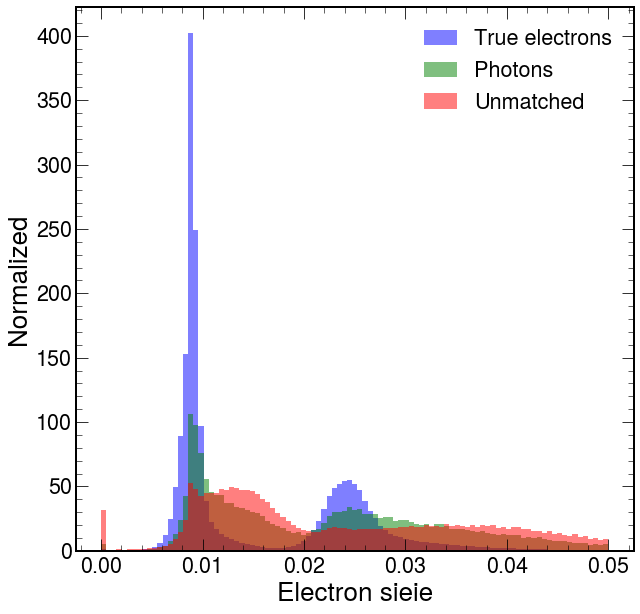

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.ROOT)

fig, ax = plt.subplots()
ax.set_xlabel('Electron sieie')
common_opts = {
    'alpha': 0.5,
    'bins': np.linspace(0, 0.05, 100),
    'density': True,
}
ax.hist(true_electrons.sieie.flatten(), color='blue', label='True electrons', **common_opts)
ax.hist(photon_fakes.sieie.flatten(), color='green', label='Photons', **common_opts)
ax.hist(unmatched.sieie.flatten(), color='red', label='Unmatched', **common_opts)
ax.legend()
ax.set_ylabel('Normalized' if common_opts['density'] else 'Events')

Shower shape variables disti

$\sigma_{i\eta i\eta}$ (`Electron.sieie`) is the energy-weighted standard deviation of integer  eta (one per crystal) within the 5×5 crystal cluster centered at the crystal with maximum energy:

$$ \sigma_{i\eta i\eta} = \frac{\sum_{i}^{5x5} w_i (i\eta_i - i\eta_{\text{seed}})}{\sum_i^{5x5} w_i}, \quad w_i = \max(0, 4.7 + \ln E_i - \ln E_{5x5}),$$

where the sum runs over the 5 × 5 crystal matrix around the most energetic crystal in the SuperCluster, and the eta distances are measured in units of the crystal size in the eta direction. This variable represents the second moment of the energy distribution along the eta coordinate.

$R_9$ (`Electron.r9`) is the ratio of the energy deposited in ECAL inside a 3 × 3 crystal matrix centered on the most energetic crystal in the supercluster and the superCluster raw energy.

$H/E$ (`Electron.hoe`) is the ratio of the energy deposited in the single closest HCAL tower to the supercluster position inside a cone of radius 0.15 in the eta - phi plane centered on the photon direction and the energy deposited in ECAL to that supercluster.

Isolation variables are blah.

   * PF Photon Isolation (IPh): Sum of Et of all PF photons which are not in the “footprint” of the candidate photon and are within a cone of DeltaR = 0.3.
   * PF Charged Hadron Isolation (ICh ): Sum of Pt of all PF charged hadrons which are associated to the primary vertex, not in the “footprint” of the candidate photon, and within a cone of DeltaR = 0.3.
   * PF Neutral Hadron Isolation (INh ): Sum of Et of all PF neutral hadrons which are not in the “footprint” of the candidate photon and are within a cone of DeltaR = 0.3.

Note: The photon isolation cone is also susceptible to pileup from interactions not corresponding to the primary vertex. The correction from the pile-up energy contribution to the photon identification is applied using the following equation:

$$Iso = Iso_{\text{raw}} - (\rho * \text{EA}(|\eta|)),$$

where $\rho$ is the event average energy density computed using FastJet.  $\rho$ is the median background density per unit area and a measure of the pile up activity in the event.  The effective area is defined as the ratio of the slope obtained from linearly fitting Iso(Nvtx ) to the one from linearly Jets fitting Rho_event(Nvtx). The values of effective area for all three isolation criteria (photon, neutral and charged) are provided by the EGamma POG separately for barrel and endcap regions.

### Electron-specific variables
The conversion-safe electron veto
This cut replaces the detector based pixel seed used to distinguish between photon and electron. It checks the DeltaR distance between the photon direction and the nearest electron track and remove photons if there is a GsfElectron matching to the photon supercluster, with no missing hits and having no matching reconstructed conversion.

Electron mini isolation: Uses a cone whose size varies as a function of the electron pT in order to reduce accidental overlap from hard scatter or pileup processes.